In [1]:
import os
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter, shift
import math, random

# Create dataset folder
os.makedirs("data/seq_01", exist_ok=True)

H, W = 128, 128
T = 6  # number of frames in the sequence

def perlin_noise(shape, seed=None):
    if seed is not None:
        np.random.seed(seed)
    noise = np.random.rand(*shape)
    noise = gaussian_filter(noise, sigma=4)
    noise = (noise - noise.min()) / (noise.max() - noise.min())
    return noise

# base cloud pattern
base = perlin_noise((H, W), seed=42)

# generate frames
for t in range(T):
    # simulate motion by shifting the cloud pattern
    moved = shift(base, shift=(t*1.2, t*1.0), mode='wrap')
    # convert to RGB (white clouds on blue sky)
    img = np.zeros((H, W, 3), dtype=np.float32)
    img[..., 2] = 0.9  # blue background
    cloud_layer = moved * 0.9
    img[..., 0] = cloud_layer
    img[..., 1] = cloud_layer
    img[..., 2] = img[..., 2] + moved*0.2
    img = np.clip(img, 0, 1)

    # save
    Image.fromarray((img*255).astype(np.uint8)).save(f"data/seq_01/frame_{t:02d}.png")

print("Dataset created! Check data/seq_01/")


Dataset created! Check data/seq_01/


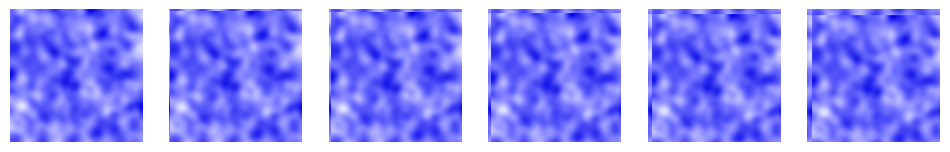

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import glob

files = sorted(glob.glob("data/seq_01/*.png"))

plt.figure(figsize=(12,3))
for i, f in enumerate(files):
    img = Image.open(f)
    plt.subplot(1,6,i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()


In [3]:
import torch
import torch.nn as nn
import numpy as np

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4*hidden_dim, 3, padding=1)

    def forward(self, x, state):
        h, c = state
        combined = torch.cat([x, h], dim=1)
        out = self.conv(combined)
        i, f, o, g = torch.chunk(out, 4, dim=1)
        i = torch.sigmoid(i); f = torch.sigmoid(f); o = torch.sigmoid(o); g = torch.tanh(g)
        c_new = f*c + i*g
        h_new = o * torch.tanh(c_new)
        return h_new, c_new

    def init_state(self, B, H, W, device):
        return (torch.zeros(B, self.hidden_dim, H, W, device=device),
                torch.zeros(B, self.hidden_dim, H, W, device=device))

class MiniCloudPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Conv2d(3, 32, 3, padding=1)
        self.lstm = ConvLSTMCell(32, 32)
        self.dec = nn.Conv2d(32, 3, 3, padding=1)

    def forward(self, seq):
        B, T, C, H, W = seq.shape
        state = self.lstm.init_state(B, H, W, seq.device)
        for t in range(T-1):
            x = torch.relu(self.enc(seq[:, t]))
            state = self.lstm(x, state)
        h, _ = state
        out = torch.sigmoid(self.dec(h))
        return out


In [4]:
import torch
from PIL import Image
import numpy as np

def load_sequence(path):
    frames = sorted(glob.glob(path + "/*.png"))
    seq = []
    for f in frames:
        img = Image.open(f).convert("RGB").resize((128,128))
        arr = np.array(img)/255.0
        arr = arr.transpose(2,0,1)  # C, H, W
        seq.append(arr)
    seq = np.stack(seq)  # (T, C, H, W)
    return torch.tensor(seq, dtype=torch.float32)

seq = load_sequence("data/seq_01")
seq.shape


torch.Size([6, 3, 128, 128])

In [5]:
model = MiniCloudPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# prepare batch: (B, T, C, H, W)
inp = seq.unsqueeze(0)  # B=1
target = seq[-1].unsqueeze(0)  # last frame

# train for few steps
for step in range(200):
    optimizer.zero_grad()
    pred = model(inp)
    loss = loss_fn(pred, target)
    loss.backward()
    optimizer.step()
    if step % 20 == 0:
        print("step", step, "loss:", float(loss))


/tmp/ipython-input-1381449768.py:17: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print("step", step, "loss:", float(loss))


step 0 loss: 0.09017454832792282
step 20 loss: 0.011385631747543812
step 40 loss: 0.003974849823862314
step 60 loss: 0.001110936515033245
step 80 loss: 0.0006997981108725071
step 100 loss: 0.0005799398059025407
step 120 loss: 0.0005071749328635633
step 140 loss: 0.000449675862910226
step 160 loss: 0.0004050488641951233
step 180 loss: 0.0003758580714929849


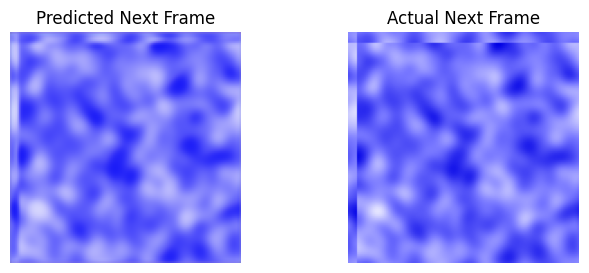

In [6]:
pred_img = pred.detach().squeeze(0).permute(1,2,0).numpy()
real_img = target.squeeze(0).permute(1,2,0).numpy()

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.title("Predicted Next Frame")
plt.imshow(pred_img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Actual Next Frame")
plt.imshow(real_img)
plt.axis("off")
plt.show()


In [7]:
import imageio

imageio.imwrite("predicted_frame.png", (pred_img*255).astype(np.uint8))
imageio.imwrite("actual_frame.png", (real_img*255).astype(np.uint8))



In [8]:
# Generate many sequences quickly (run in Colab)
import os, numpy as np, random
from PIL import Image
from scipy.ndimage import gaussian_filter, shift
os.makedirs("data_many", exist_ok=True)
H,W = 128,128
SEQS = 60
T = 6
def perlin_noise(shape, seed=None):
    if seed is not None:
        np.random.seed(seed)
    noise = np.random.rand(*shape)
    noise = gaussian_filter(noise, sigma=4)
    noise = (noise - noise.min()) / (noise.max()-noise.min()+1e-9)
    return noise

for s in range(SEQS):
    base = perlin_noise((H,W), seed=random.randint(0,99999))
    dx = random.uniform(-1.2,1.2); dy = random.uniform(-1.2,1.2)
    seq_dir = f"data_many/seq_{s:03d}"
    os.makedirs(seq_dir, exist_ok=True)
    for t in range(T):
        moved = shift(base, shift=(t*dy, t*dx), mode='wrap')
        img = np.zeros((H,W,3), dtype=np.float32)
        img[...,2] = 0.9
        cloud = moved*0.9
        img[...,0] = cloud; img[...,1] = cloud; img[...,2] = img[...,2] + moved*0.2
        img = np.clip(img,0,1)
        Image.fromarray((img*255).astype('uint8')).save(f"{seq_dir}/frame_{t:02d}.png")
print("Generated", SEQS, "sequences in data_many/")


Generated 60 sequences in data_many/


In [9]:
# install piq if needed for SSIM, or use simple implementation
!pip install pytorch-msssim --quiet

import torch
import torch.nn as nn
from pytorch_msssim import ssim

def combined_loss(pred, target, alpha=0.84):
    # pred, target: (B,C,H,W) in [0,1]
    l1 = torch.nn.functional.l1_loss(pred, target)
    # pytorch_msssim returns mean SSIM in [0,1], higher is better -> convert to loss
    s = ssim(pred, target, data_range=1.0, size_average=True)
    ssim_loss = 1.0 - s
    return alpha * l1 + (1.0 - alpha) * ssim_loss


In [10]:
import glob, numpy as np, torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import random

# Simple dataset reading sequences
class SeqDataset(Dataset):
    def __init__(self, root, seq_len=6, resize=(128,128)):
        self.seq_dirs = sorted(glob.glob(root + "/seq_*"))
        self.seq_len = seq_len
        self.resize = resize
    def __len__(self):
        return len(self.seq_dirs)
    def __getitem__(self, idx):
        files = sorted(glob.glob(self.seq_dirs[idx] + "/*.png"))
        frames = []
        for f in files[:self.seq_len]:
            im = Image.open(f).convert("RGB").resize(self.resize)
            arr = np.array(im)/255.0
            arr = np.transpose(arr, (2,0,1))
            frames.append(arr.astype('float32'))
        seq = np.stack(frames)  # (T,C,H,W)
        src = seq[:-1]  # input frames
        tgt = seq[-1]   # target
        return torch.tensor(src), torch.tensor(tgt)

dataset = SeqDataset("data_many")
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

# Use the MiniCloudPredictor model from before (or paste model cell)
model = MiniCloudPredictor().cuda() if torch.cuda.is_available() else MiniCloudPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

epochs = 30
for ep in range(epochs):
    model.train()
    total_loss = 0.0
    for src, tgt in loader:
        # src: (B, T-1, C, H, W), tgt: (B, C, H, W)
        src = src.cuda() if torch.cuda.is_available() else src
        tgt = tgt.cuda() if torch.cuda.is_available() else tgt
        optimizer.zero_grad()
        pred = model(src)
        loss = combined_loss(pred, tgt)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * src.size(0)
    avg = total_loss / len(dataset)
    print(f"Epoch {ep+1}/{epochs} avg_loss: {avg:.6f}")
# save:
torch.save(model.state_dict(), "cloud_mini_improved.pth")
print("Saved model.")


Epoch 1/30 avg_loss: 0.264642
Epoch 2/30 avg_loss: 0.201750
Epoch 3/30 avg_loss: 0.129315
Epoch 4/30 avg_loss: 0.090672
Epoch 5/30 avg_loss: 0.071304
Epoch 6/30 avg_loss: 0.064911
Epoch 7/30 avg_loss: 0.058810
Epoch 8/30 avg_loss: 0.051459
Epoch 9/30 avg_loss: 0.042655
Epoch 10/30 avg_loss: 0.035259
Epoch 11/30 avg_loss: 0.030440
Epoch 12/30 avg_loss: 0.026942
Epoch 13/30 avg_loss: 0.024872
Epoch 14/30 avg_loss: 0.023820
Epoch 15/30 avg_loss: 0.022678
Epoch 16/30 avg_loss: 0.022258
Epoch 17/30 avg_loss: 0.021612
Epoch 18/30 avg_loss: 0.020993
Epoch 19/30 avg_loss: 0.020221
Epoch 20/30 avg_loss: 0.019232
Epoch 21/30 avg_loss: 0.018614
Epoch 22/30 avg_loss: 0.018205
Epoch 23/30 avg_loss: 0.017503
Epoch 24/30 avg_loss: 0.017230
Epoch 25/30 avg_loss: 0.016916
Epoch 26/30 avg_loss: 0.016242
Epoch 27/30 avg_loss: 0.015865
Epoch 28/30 avg_loss: 0.015353
Epoch 29/30 avg_loss: 0.015145
Epoch 30/30 avg_loss: 0.015053
Saved model.


In [11]:
from PIL import ImageFilter, Image
import numpy as np

def sharpen_image(arr):
    # arr: H,W,C float [0,1]
    img = Image.fromarray((arr*255).astype('uint8'))
    img = img.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))
    return np.array(img)/255.0

# Use this on pred_img before saving for README/resume
pred_sharp = sharpen_image(pred_img)


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

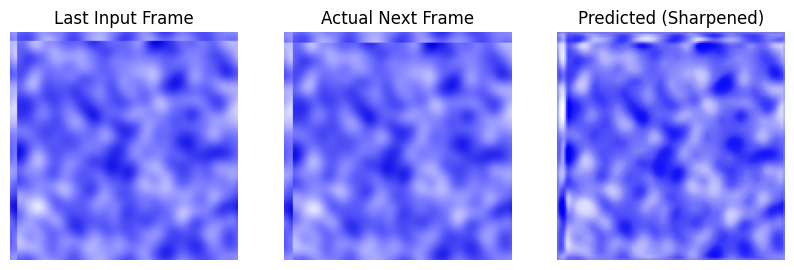

In [12]:
# visualize improved prediction
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Last Input Frame")
plt.imshow(seq[-2].permute(1,2,0).numpy())
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Actual Next Frame")
plt.imshow(seq[-1].permute(1,2,0).numpy())
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Predicted (Sharpened)")
plt.imshow(pred_sharp)
plt.axis("off")


In [13]:
import imageio
import numpy as np

# Save predicted frame (sharpened)
imageio.imwrite("predicted_final.png", (pred_sharp * 255).astype(np.uint8))

# Save actual next frame
real_img = seq[-1].permute(1,2,0).numpy()
imageio.imwrite("real_final.png", (real_img * 255).astype(np.uint8))

print("Saved predicted_final.png and real_final.png")


Saved predicted_final.png and real_final.png


In [14]:
import torch

torch.save(model.state_dict(), "cloud_mini_improved.pth")
print("Saved model as cloud_mini_improved.pth")


Saved model as cloud_mini_improved.pth
